# Madison Real Estate Data Analysis

This notebook will walk you through the data wrangling, analysis, and basic visualizations of some trends in the City of Madison Real Estate market. Real esate sales data was scraped from [assessor's website](https://www.cityofmadison.com/assessor/property/salesbyarea.cfm) and date back to January 2002. More detailed property information was downloaded from the City of Madison [data portal](https://data-cityofmadison.opendata.arcgis.com/datasets/tax-parcels-assessor-property-information).

## 0: Initial questions
I've got some questions about the Madison Real Estate market that I want to answer.
* What does the housing market look like in different parts of Madison?
* How did the housing bubble of 2006 and the market crash of 2008 impact the Madison housing market?
* Do factors like location, style, or size, or type exhibit different market behavior or does the whole market move together?
* What does the housing market supply look like over time?
* Are the price differentces between different housing options?
* Can we update the static annual property tax assesment data with recent home sales data to get an idea of what the market is doing now?
* How accurately can we project the 2018 housing market using past data?

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

## 1: Data Overview

### Assessor's Property Tax Data

Let's start by examining the columns of the property tax data, which are in the first line of the file:

In [2]:
tax_file_name = 'Tax_Parcels_Assessor_Property_Information.csv'

with open(tax_file_name,'r') as f:
    header = f.readline()
print(header)
header.count(',')

ï»¿OBJECTID,Parcel,XRefParcel,Address,DateParcelChanged,PropertyClass,PropertyUse,AssessmentArea,AreaName,MoreThanOneBuild,HomeStyle,DwellingUnits,Stories,YearBuilt,Bedrooms,FullBaths,HalfBaths,TotalLivingArea,FirstFloor,SecondFloor,ThirdFloor,AboveThirdFloor,FinishedAttic,Basement,FinishedBasement,ExteriorWall1,ExteriorWall2,Fireplaces,CentralAir,PartialAssessed,AssessedByState,CurrentLand,CurrentImpr,CurrentTotal,PreviousLand,PreviousImpr,PreviousTotal,NetTaxes,SpecialAssmnt,OtherCharges,TotalTaxes,LotSize,Zoning1,Zoning2,Zoning3,Zoning4,FrontageFeet,FrontageStreet,WaterFrontage,TIFDistrict,TaxSchoolDist,AttendanceSchool,ElementarySchool,MiddleSchool,HighSchool,Ward,StateAssemblyDistrict,RefuseDistrict,RefuseURL,PreviousLand2,PreviousImpr2,PreviousTotal2,AlderDistrict,AssessmentChangeDate,BlockNumber,BuildingDistrict,CapitolFireDistrict,CensusTract,ConditionalUse,CouncilHold,DateAdded,DeedPage,DeedRestriction,DeedVolume,ElectricalDistrict,EnvHealthDistrict,ExemptionType,FireDistrict,

146

Y I K E S. Well *that's* indecipherable. Lets try to sort these 146 columns into categories and get at the characteristics we actually want to use in our model. Using all 146 of the columns to model home values would likely lead to overfitting and many of the . After taking a look at these, I've picked out 9 categories: Basic Information, Assessor Values, Building characteristics, Lot characteristics, Geographical Divisions, Schools, Location caracteristics, Plotting, and Other.

We can procedurally seperate the columns into three analysis categories: indentifiers, continuous variables, and categorical or discrete varialbes. Identifiers will be unique to each entry (such as `Address`). Categorical varibales will be strings (`FrontageStreet`), have relatively few unique posibilities (`StreetNoise`), or be geographically clustered (`PoliceSector`). Continuous variables will have a large number of possible values, but each value won't necessarily be unique (`TotalLivingArea`).

In [3]:
df = pd.read_csv(tax_file_name, index_col=1, low_memory=False)
all_tax_columns = df.columns

C:\Users\Nina\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Nina\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Number of columns')

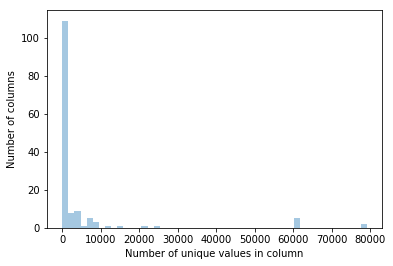

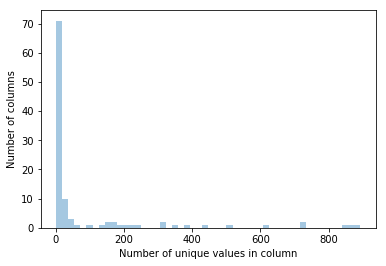

In [4]:
counts = np.full(df.columns.shape,0)
for idx, col in enumerate(df.columns):
    counts[idx] = df[col].unique().shape[0]
sns.distplot(counts, kde=False)
plt.xlabel('Number of unique values in column')
plt.ylabel('Number of columns')
plt.figure()
sns.distplot(counts[np.where(counts<1000)], kde=False)
plt.xlabel('Number of unique values in column')
plt.ylabel('Number of columns')

In [5]:
ID_col = []; map_col = []; cont_col = []; cat_col = []
for idx, col in enumerate(df.columns):
    if counts[idx] > 70000:
        ID_col.append(col)
    elif counts[idx] > 40000:
        map_col.append(col)
    elif counts[idx] < 275 or df[col].dtype == 'object':
        cat_col.append(col)
    else:
        cont_col.append(col)
print("IDs: ", ID_col,'\n\nMapping: ', map_col,'\n\nContinuous: ', cont_col)#,'\n\nCategorical:', cat_col)

IDs:  ['OBJECTID', 'Address'] 

Mapping:  ['XRefParcel', 'XCoord', 'YCoord', 'SHAPESTArea', 'SHAPESTLength'] 

Continuous:  ['AssessmentArea', 'TotalLivingArea', 'FirstFloor', 'SecondFloor', 'ThirdFloor', 'AboveThirdFloor', 'FinishedAttic', 'Basement', 'FinishedBasement', 'CurrentLand', 'CurrentImpr', 'CurrentTotal', 'PreviousLand', 'PreviousImpr', 'PreviousTotal', 'NetTaxes', 'SpecialAssmnt', 'OtherCharges', 'TotalTaxes', 'LotSize', 'FrontageFeet', 'PreviousLand2', 'PreviousImpr2', 'PreviousTotal2', 'LotDepth', 'LotNumber', 'LotWidth', 'TifImpr', 'TifLand', 'TrafficAnalysisZone', 'HouseNbr', 'StreetID']


We have a few of obvious mis-identified collumns in this sort. First are `XRefParcel` and `LotNumber`, which is more of an identifier. `HouseNbr` and `StreetID` are both contained in the address, so they can be dropped entirely. Finally, `AssessmentArea` and `TrafficAnalysisZone` are geographic categoricals. Note that the remaining continuous variables are related to home size, lot size, and property taxes. To capture the home and lot characteristics with the fewest number of variables, we will use `TotalLivingArea`, `LotSize`, and `FrontageFeet`.

In [6]:
columns_to_drop = ['HouseNbr','StreetID','LotNumber']
try:
    ID_col.append('XRefParcel'); ID_col.append('LotNumber')
    map_col.remove('XRefParcel'); cont_col.remove('LotNumber')

    cont_col.remove('HouseNbr'); cont_col.remove('StreetID')
    cat_col.append('AssessmentArea'); cat_col.append('TrafficAnalysisZone')
    cont_col.remove('AssessmentArea'); cont_col.remove('TrafficAnalysisZone')
except ValueError:
    pass
model_columns = ['TotalLivingArea','LotSize','FrontageFeet']

In [8]:
# Basic information
basic = ['OBJECTID','Parcel','XRefParcel','Address','Unit','PropertyClass','PropertyUse']
plotting = ['XCoord','YCoord','SHAPESTArea','SHAPESTLength']
df = pd.read_csv(tax_file_name, index_col='Parcel', usecols=basic)
df.head()

,OBJECTID,XRefParcel,Address,PropertyClass,PropertyUse,Unit
Parcel,,,,,,
60801101019,41,60801101019,2001 Rae Ln,Residential,Single family,NaN
60801101027,29,60801101027,2005 Rae Ln,Residential,Single family,NaN
60801101035,28,60801101035,2009 Rae Ln,Residential,Single family,NaN
60801101043,27,60801101043,2013 Rae Ln,Residential,Single family,NaN
60801101051,26,60801101051,2017 Rae Ln,Residential,Single family,NaN


In [11]:
df.describe(include='O')

,Address,PropertyClass,PropertyUse,Unit
count,79027,79027,79026,12678
unique,79026,4,304,2793
top,1 N Pinckney St,Residential,Single family,2
freq,2,71961,46837,355


It looks like we have a duplicate address, 1 N Pinckney St is in the database twice! It also looks most of the ~72,000 residentail properties don't have `Unit` defined. 46,800 properties are single family homes and 12,700 have `Unit`, but that only totals 59,500 of the 72,000 residental properties. There is probably more to unpack in the `PropertyUse` column.

We are also only considering residential property sales, so we will only include rows where `PropertyClass` is `'Residential'`.

In [7]:
print(df.PropertyClass.unique())
print(df.Unit.unique())

['Residential' 'Commercial' 'Agricultural' 'Industrial']
[nan 'CDM' 'H' ... '4118' 'U1' 'P416']


In [29]:
# Basic Identifiers
basic = ['OBJECTID','Parcel','XRefParcel','Address','Unit','PropertyClass','PropertyUse']
# Plotting
plotting = ['XCoord','YCoord','SHAPESTArea','SHAPESTLength']
# Assessor's values
assessed = ['CurrentLand','CurrentImpr','CurrentTotal','PreviousLand',
           'PreviousImpr','PreviousTotal']
# Building characteristics
build_info = ['MoreThanOneBuild','HomeStyle','DwellingUnits','TotalDwellingUnits',
              'Stories','YearBuilt','MaxConstructionYear',
              'Bedrooms','FullBaths','HalfBaths','TotalLivingArea',
              'FirstFloor','SecondFloor','ThirdFloor','AboveThirdFloor',
              'FinishedAttic','Basement','FinishedBasement','ExteriorWall1',
              'ExteriorWall2','Fireplaces','CentralAir','Landmark']

# Lot characteristics
lot_info = ['LotNumber','LotType1','LotType2','LotSize','LotWidth','LotDepth',
            'FrontageFeet','FrontageStreet','WaterFrontage','TypeWaterFrontage',
            'RailroadFrontage','WetlandInfo','Zoning1','Zoning2','Zoning3','Zoning4']

# Geographical divisions
geo_div = ['AssessmentArea','AreaName','RefuseDistrict','AlderDistrict',
           'CensusTract','TrafficAnalysisZone','TIFDistrict',
           'TaxSchoolDist','BuildingDistrict','CapitolFireDistrict',
           'ElectricalDistrict','EnvHealthDistrict','FireDistrict','HeatingDistrict',
           'NeighborhoodDesc','NeighborhoodPrimary','NeighborhoodSub',
           'NeighborhoodVuln','PlanningDistrict','PlumbingDistrict',
           'PoliceDistrict','PoliceSector','SenateDistrict','StormOutfall','SupervisorDistrict',
           'UrbanDesignDistrict','FireDemandZone','UWPolice','Ward']
'''
#df = pd.read_csv(tax_file_name, index_col=1, usecols=basic+geo_div, dtype = 'str')
#df = df[df.PropertyClass == 'Residential'].drop('PropertyClass', 1)
#df.describe(include=['O']).iloc[1]

geo_div_coutns = df.describe(include=['O']).iloc[1]
good_counts = geo_div_coutns[geo_div_coutns > 50][geo_div_coutns <1000]
print(good_counts)
trial_geo_divs = good_counts.keys()

print(df[trial_geo_divs].describe(include=['O']))
'''

# Schools:
school_info = ['AttendanceSchool','ElementarySchool','MiddleSchool','HighSchool']
# Location Info
loc_info = ['FloodPlain','FuelStorageProximity','LandfillProximity',
            'LandfillRemediation','LocalHistoricalDist','NationalHistoricalDist',
            'NoiseAirport','NoiseRailroad','NoiseStreet','ParkProximity']
# Plotting info
plotting = ['XCoord','YCoord','SHAPESTArea','SHAPESTLength']

,CurrentLand,CurrentImpr,CurrentTotal,PreviousLand,PreviousImpr,PreviousTotal
count,7.196100e+04,7.196100e+04,7.196100e+04,7.196100e+04,7.196100e+04,7.196100e+04
mean,6.165191e+04,1.633170e+05,2.249689e+05,5.876317e+04,1.524948e+05,2.112580e+05
std,5.531658e+04,1.128136e+05,1.513396e+05,5.345732e+04,1.104293e+05,1.471892e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.050000e+04,1.069000e+05,1.505000e+05,2.950000e+04,9.680000e+04,1.389000e+05
50%,5.690000e+04,1.513000e+05,2.101000e+05,5.460000e+04,1.392000e+05,1.950000e+05
75%,8.160000e+04,2.096000e+05,2.864000e+05,7.720000e+04,1.961000e+05,2.694000e+05
max,1.558100e+06,4.356900e+06,4.500000e+06,1.483900e+06,4.869900e+06,5.000000e+06


At least one of the properties are assessed at 0. `df[df.CurrentTotal == 0].shape` returns `(2767, 11)`. Properties can be assesed for property tax reasons at lower than their actual value, we can assume this is the case for these properties. We should be wary of using the property tax assesments for actual home values. That said, these assesments can give us some perspective on land values. 

Our Building Information and Lot Information lists are below. Many of these columns will probably be important, but others probably won't be, especially the lot information.

In [62]:
# Building characteristics
build_info = ['MoreThanOneBuild','HomeStyle','DwellingUnits','TotalDwellingUnits',
              'Stories','YearBuilt','MaxConstructionYear',
              'Bedrooms','FullBaths','HalfBaths','TotalLivingArea',
              'FirstFloor','SecondFloor','ThirdFloor','AboveThirdFloor',
              'FinishedAttic','Basement','FinishedBasement','ExteriorWall1',
              'ExteriorWall2','Fireplaces','CentralAir','Landmark']

# Lot characteristics
lot_info = ['LotNumber','LotType1','LotType2','LotSize','LotWidth','LotDepth',
            'FrontageFeet','FrontageStreet','WaterFrontage','TypeWaterFrontage',
            'RailroadFrontage','WetlandInfo','Zoning1','Zoning2','Zoning3','Zoning4']

Next we have geographic devisions. These will be very handy when we are trying to determine location value vs. house value. However, we have way too many, we will at most need to use one or two. Let's figure out which of these will be useful for us. For a first step, we can elimiate geographic categories that have too few categories or have too many unassigned values. Some of these columns also have mixed value types, so lets load them all as strings.

In [56]:
# Geographical divisions
geo_div = ['AssessmentArea','AreaName','RefuseDistrict','AlderDistrict',
           'CensusTract','TrafficAnalysisZone','TIFDistrict',
           'TaxSchoolDist','BuildingDistrict','CapitolFireDistrict',
           'ElectricalDistrict','EnvHealthDistrict','FireDistrict','HeatingDistrict',
           'NeighborhoodDesc','NeighborhoodPrimary','NeighborhoodSub',
           'NeighborhoodVuln','PlanningDistrict','PlumbingDistrict',
           'PoliceDistrict','PoliceSector','SenateDistrict','StormOutfall','SupervisorDistrict',
           'UrbanDesignDistrict','FireDemandZone','UWPolice','Ward']

df = pd.read_csv(tax_file_name, index_col=1, usecols=basic+geo_div, dtype = 'str')
df = df[df.PropertyClass == 'Residential'].drop('PropertyClass', 1)
df.describe(include=['O']).iloc[1]

OBJECTID               71961
XRefParcel             55506
Address                71961
PropertyUse               11
AssessmentArea           462
AreaName                 410
TIFDistrict               15
TaxSchoolDist              0
Ward                     128
RefuseDistrict            22
AlderDistrict             21
BuildingDistrict           5
CapitolFireDistrict        2
CensusTract               56
ElectricalDistrict         4
EnvHealthDistrict         28
FireDistrict               3
HeatingDistrict            6
NeighborhoodDesc          11
NeighborhoodPrimary       17
NeighborhoodSub            3
NeighborhoodVuln           6
PlanningDistrict           4
PlumbingDistrict           4
PoliceDistrict             6
PoliceSector             107
SenateDistrict             4
SupervisorDistrict        22
TrafficAnalysisZone      333
UWPolice                   1
UrbanDesignDistrict       10
Unit                    2701
StormOutfall             207
FireDemandZone             1
Name: unique, 

Our ID categories have thousands of entries (which makes sense) and many of our other geographic groupings have very few categories. Lets get rid of those columns and examine the intermediate ones.

In [57]:
geo_div_coutns = df.describe(include=['O']).iloc[1]
good_counts = geo_div_coutns[geo_div_coutns > 50][geo_div_coutns <1000]
print(good_counts)
trial_geo_divs = good_counts.keys()

In [61]:
df[trial_geo_divs].describe(include=['O'])

,AssessmentArea,AreaName,Ward,CensusTract,PoliceSector,TrafficAnalysisZone,StormOutfall
count,71961,71961,71961,71961,71961,71961,46266
unique,462,410,128,56,107,333,207
top,6601,Residential Exempt,38,4.03,510,98,SR01A106
freq,1693,1693,3133,4559,2084,2070,1860


Notice that `StormOutfall` has roughly 25,000 missing values, so that will probably make a poor geographic devider. We will do spacial plots of these categories later to determine which we want to use for our analysis. 

The school and location info might have some overlap with the geographical devisions, but may have different impacts on the data. For example, we can expect `StreetNoise` to have an impact on property values, has to do with the location, but isn't a single isolated geographic region.

The plotting information will be critical for visualizing our data. Unfortunately, the `XCoord` and `YCoord` values are arbitratry units and will need to be transformed to latitude and longitude for plotting on a map.

### Property Sale Data
As stated before, this data was scraped from a website and was very ugly, with missing fields and inconsistant formating. I extracted only the Address, Price, Parcel, and Date.

In [142]:
sales_file_name = 'Sales.csv'
df = pd.read_csv(sales_file_name, parse_dates = ['Date'])
df.head()

,Address,Price,Parcel,Date
0,5207 Bliss St,155000,71034108219,2012-06-01
1,5207 Bliss St,192000,71034108219,2007-10-01
2,5225 Brandenburg Way,180000,71034107071,2007-07-01
3,5248 Brandenburg Way,193000,71034106106,2007-01-01
4,2317 Carling Dr,27000,60905214180,2012-11-01


Let's take a look at the sales data over time.

(array([730851.]), array([736664.]))

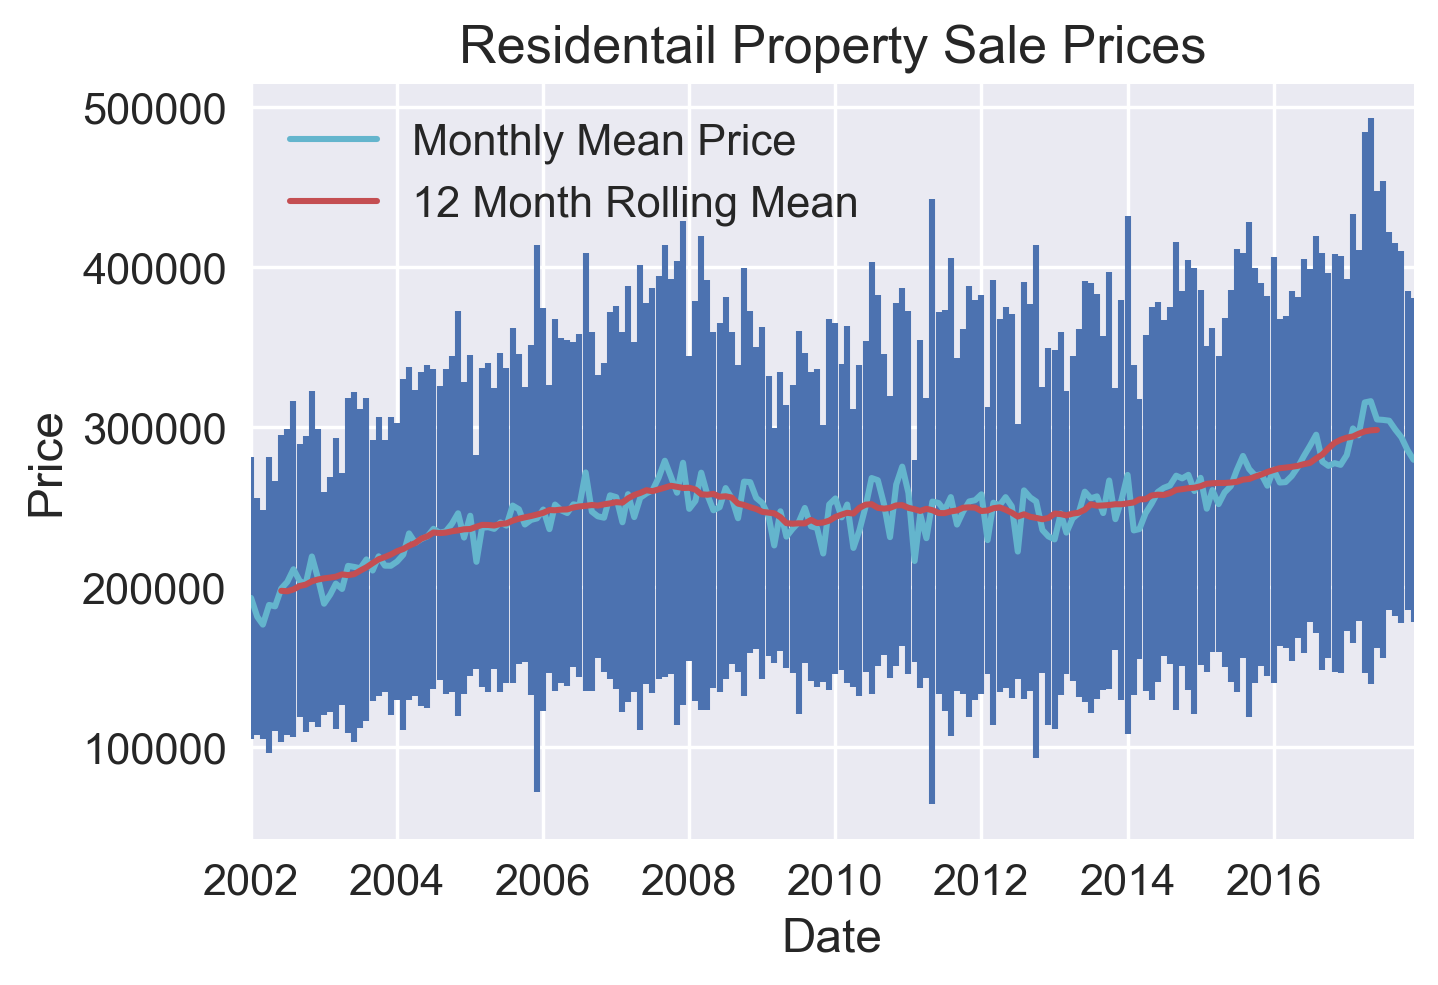

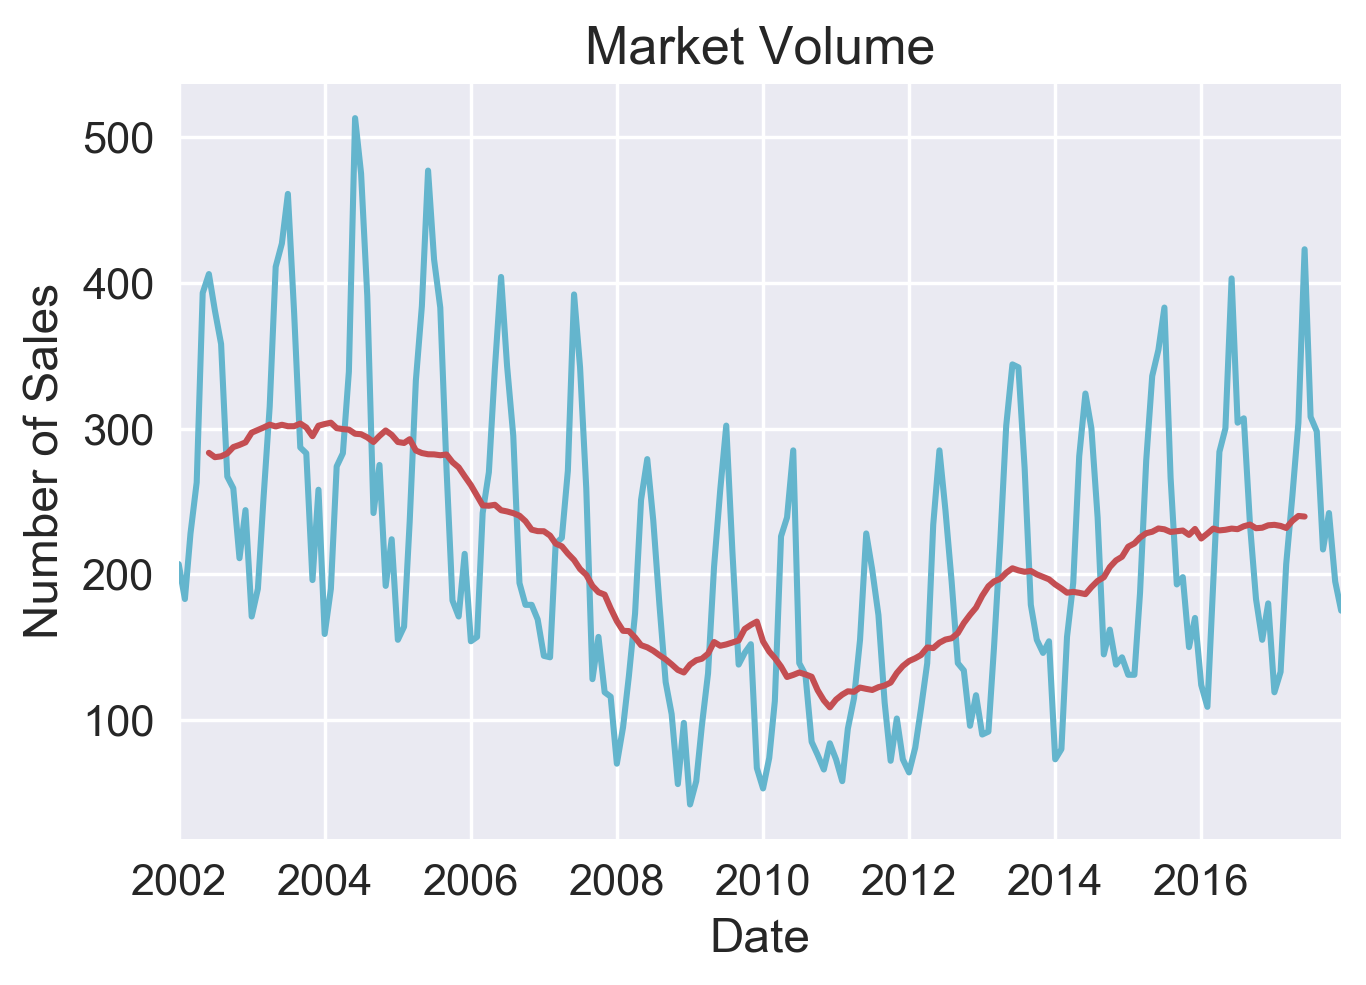

In [247]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# Data Workup
by_date = df[df.Date < max_date].groupby('Date')
means_by_date = by_date.mean()
rolling_means = running_mean(means_by_date.Price.values,12)
volume = by_date.count()
std_by_date = by_date.std()
dates = by_date.Date.unique()

### PLOTTING
# Price over time
plt.figure(dpi=250)
plt.errorbar(dates, means_by_date['Price'], yerr=std_by_date['Price'],
             marker='', linestyle='')
plt.plot(dates, means_by_date['Price'], color='C5')
plt.plot(dates[5:-6], rolling_means, color='C2')
plt.legend(['Monthly Mean Price','12 Month Rolling Mean'], loc=2)
plt.ylabel('Price'); plt.xlabel('Date'); plt.title("Residentail Property Sale Prices")
plt.xlim(min(dates),max(dates))
# Volume over time
plt.figure(dpi=250)
plt.plot(dates,volume['Price'], color='C5')
plt.plot(dates[5:-6],running_mean(volume['Price'].values,12), color='C2')
plt.ylabel('Number of Sales'); plt.xlabel('Date'); plt.title("Market Volume")
plt.xlim(min(dates),max(dates))

We can see a a few very clear patterns in this market data. The market volume has large annual oscillations. By taking the 12-month rolling average, we can average out the annual oscillations to get a clearer picture of longer term market trends. We can clearly see the peak of the housing bubble in 2005 and subsequent market correction and crash in 2006 through 2008.

The annual periodicity is not as clear in the raw sales data. The larger trend also has some differences: residential unit prices trend upward until late 2007, the downturn is much less pronounced, and home prices have basically recovered by 2011. It might be tempting to conclude that the housing bubble didn't impact Madison home values like it did in the rest of the country. But before we jump to any conclusions, lets try to account for property type and quality, not just price.

But to do this we need to combine our data sets!

## 2. Quantifying Important Features
Now that we have some idea of what our datasets look like, let's take a bird's eye view of correlations between categories we think might be important. After merging our sales data with a selectoin of features from the protery tax database, we can take a look at the correlations with price.

Any house-specific paramter with fewer than 30 unique values can probably be considered categorical or discrete, not continuous. Likewise, `ParcelID` (and any feild with the same number of enterys) will be a property identifier, not a meaningful number for correlations, so we should exclude those from our inital correlation analysis as well. Because we have known non-linear trends with respect to `Date`, we can also exclude `Date` for our initial correlation analysis.

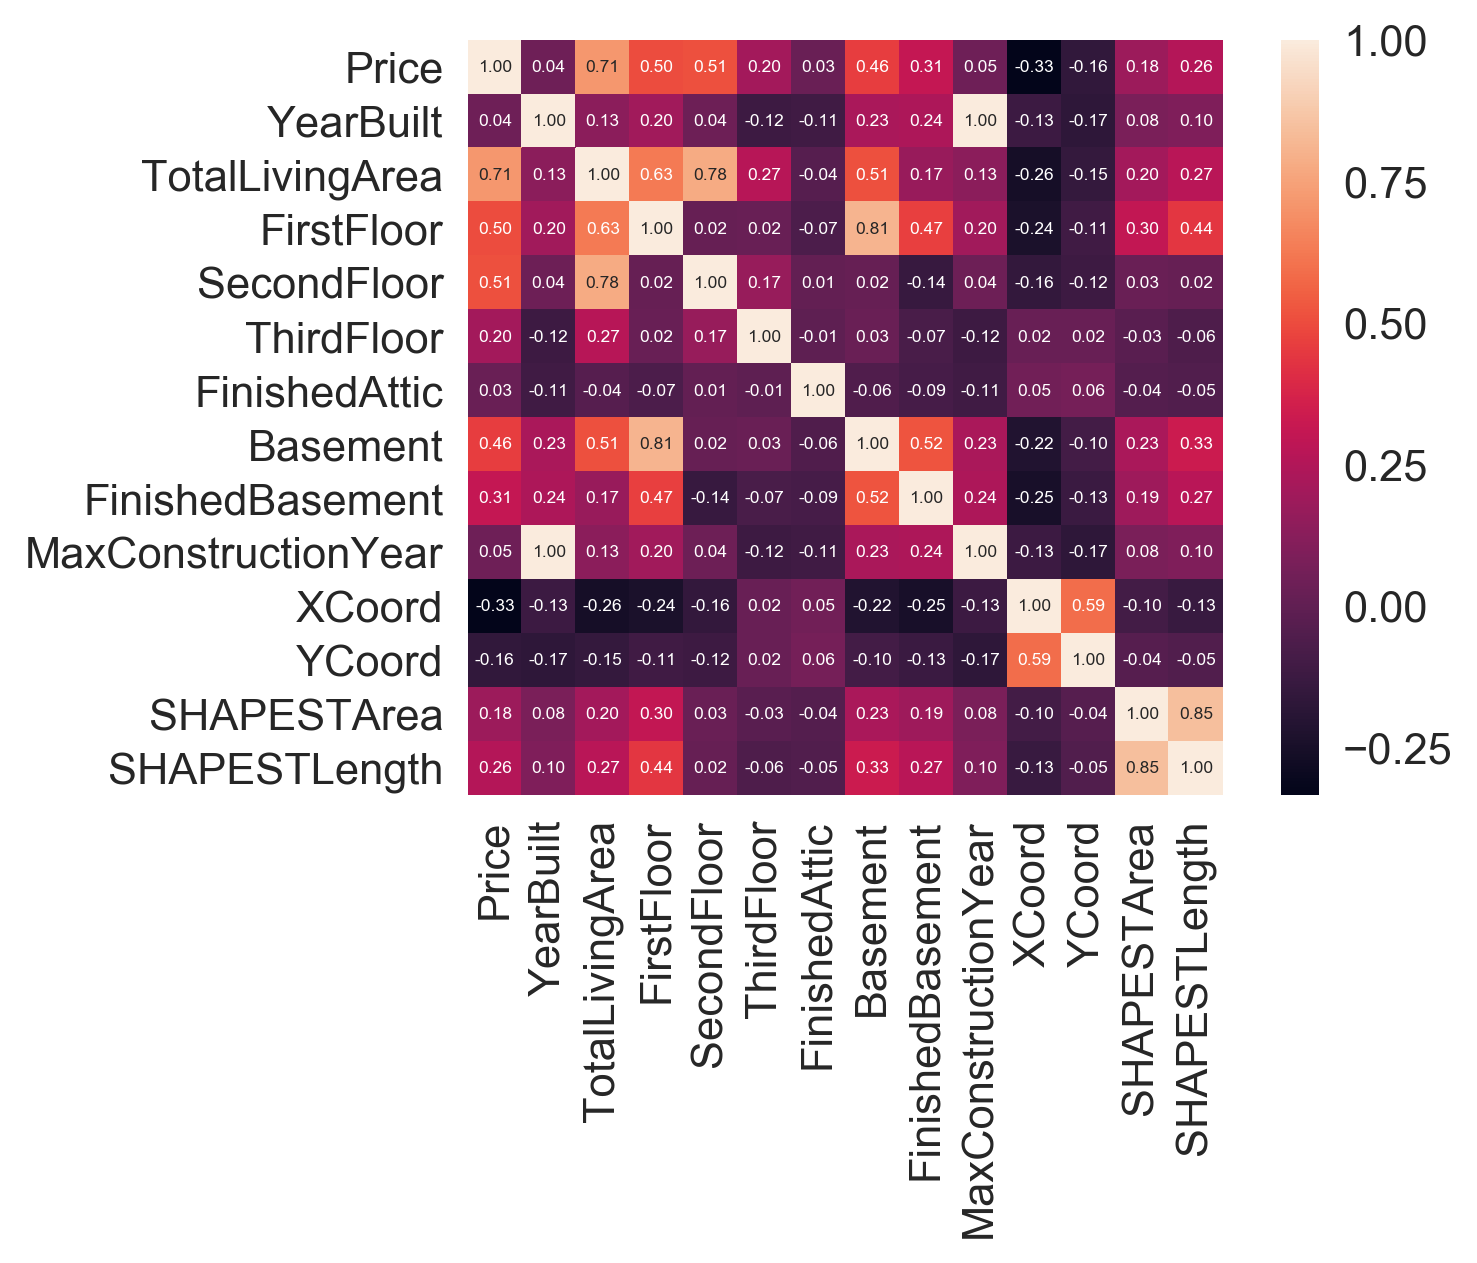

In [235]:
# Merge datasets
use_columns = ['Parcel','PropertyClass']+build_info+plotting
df_tax = pd.read_csv(tax_file_name, index_col=0, usecols=use_columns, low_memory=False)
df_tax = df_tax[df_tax.PropertyClass == 'Residential'].drop('PropertyClass', 1)

df_sales = pd.read_csv(sales_file_name, parse_dates = ['Date'])
df_sales = df_sales[df_sales.Date < max_date]

df = pd.merge(df_sales, df_tax, left_on = 'Parcel', right_index=True)

num_properties = df.Parcel.unique().shape[0]
numerical = df.copy()
for col in df.columns:
    NU = numerical[col].unique().shape[0]
    if NU < 30:
        numerical = numerical.drop(col,1)
    elif NU == num_properties:
        numerical = numerical.drop(col,1)
# other to drop:
numerical = numerical.drop('Date',1)
numerical = numerical.drop('Address',1)
cols = numerical.columns
corr_mat = np.corrcoef(numerical.values.T)
sns.set(font_scale=1.25)
plt.figure(dpi=250)
hm = sns.heatmap(corr_mat, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 5},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Let's take a look at our correlations. First, the single best predictor of property value is `TotalLivingArea`, which is not surprising; price per square foot is a common metric for a reason. In fact, the top five features most correlated to `Price` are all measures of the size of the house. So lets take another look at housing price over time, but this time using a new `PricePerSqFt` column.

(array([730851.]), array([736664.]))

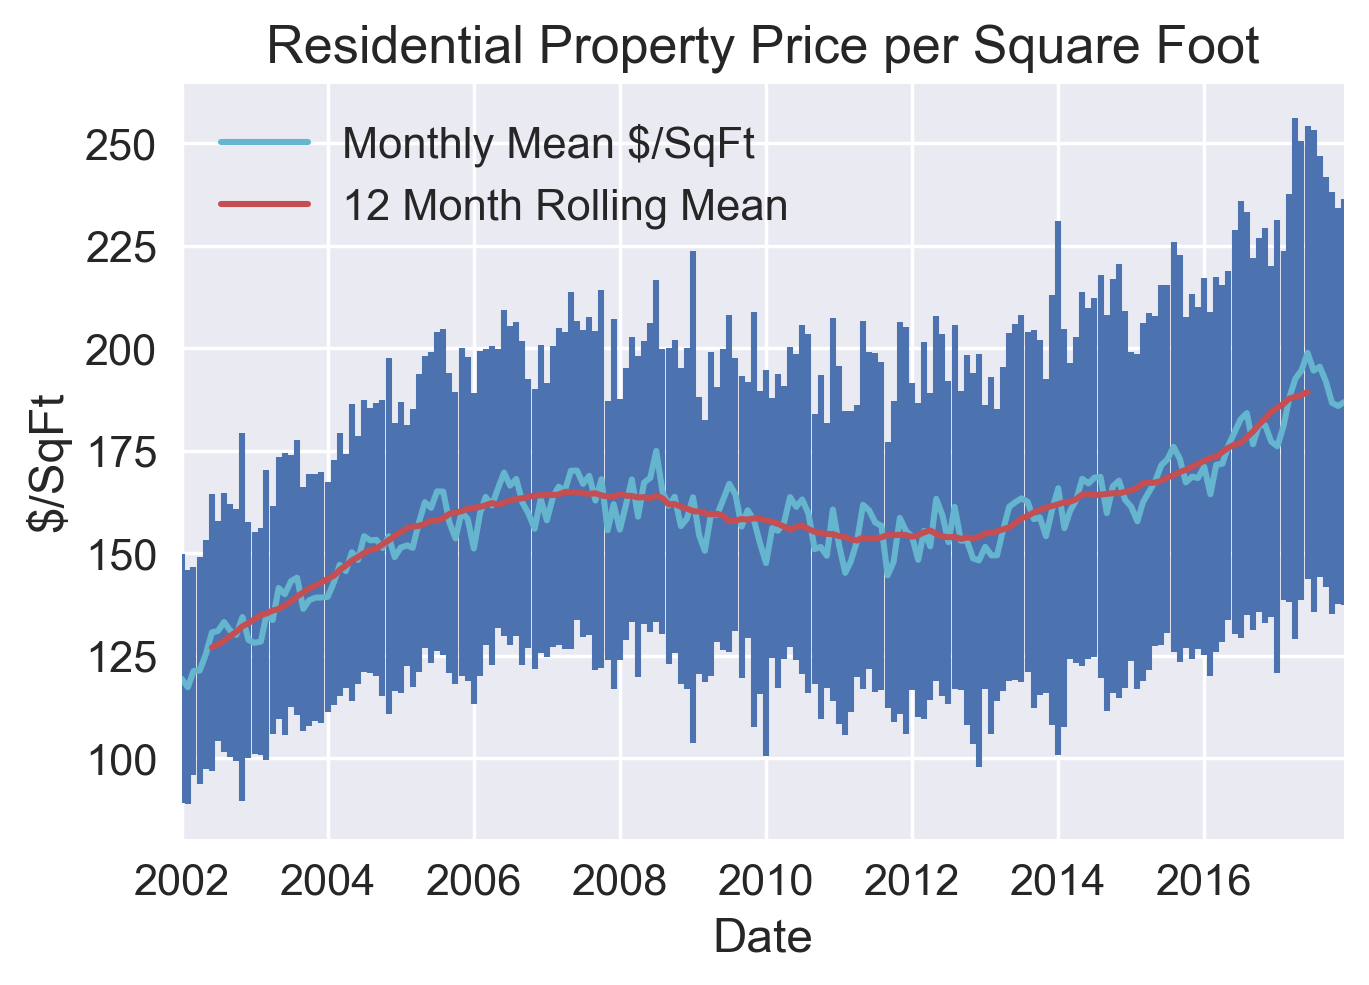

In [255]:
# first remove any rows with no living space
df = df[df.TotalLivingArea > 0]
df['PricePerSqFt'] = df.Price / df.TotalLivingArea

by_date = df[df.Date < max_date].groupby('Date')
means_by_date = by_date.PricePerSqFt.mean()
rolling_means = running_mean(means_by_date.values,12)
std_by_date = by_date.PricePerSqFt.std()
dates = by_date.Date.unique()

### PLOTTING
# Price over time
plt.figure(dpi=250)
plt.errorbar(dates, means_by_date, yerr=std_by_date,
             marker='', linestyle='')
plt.plot(dates, means_by_date, color='C5')
plt.plot(dates[5:-6], rolling_means, color='C2')
plt.legend(['Monthly Mean $/SqFt','12 Month Rolling Mean'], loc=2)
plt.ylabel('$/SqFt'); plt.xlabel('Date'); plt.title("Residential Property Price per Square Foot")
plt.xlim(min(dates),max(dates))

In [254]:
means_by_date

Date
2002-01-01    119.387548
2002-02-01    117.338640
2002-03-01    121.285017
2002-04-01    121.391723
2002-05-01    125.251316
2002-06-01    130.694281
2002-07-01           inf
2002-08-01    133.222121
2002-09-01    131.120009
2002-10-01    130.116604
2002-11-01    134.436017
2002-12-01    128.846904
2003-01-01    128.161090
2003-02-01    128.478778
2003-03-01           inf
2003-04-01    133.717909
2003-05-01    141.525770
2003-06-01    140.010662
2003-07-01           inf
2003-08-01    144.052896
2003-09-01    136.436485
2003-10-01    138.569469
2003-11-01    139.175534
2003-12-01    139.213823
2004-01-01    139.369141
2004-02-01    142.876548
2004-03-01    147.185055
2004-04-01    145.653242
2004-05-01    150.267366
2004-06-01           inf
                 ...    
2015-07-01    172.900511
2015-08-01    175.929111
2015-09-01    173.025047
2015-10-01    167.264151
2015-11-01    168.677316
2015-12-01           inf
2016-01-01    171.108192
2016-02-01    164.365890
2016-03-01    171.56